# Построение xG-модели
xG("expected goals") - модель ожидаемых голов, которая оценивает качество созданных моментов, присваивая каждому удару по воротам некоторый коэффициент опастности. Как правило, данный коэффициент представляет собой вероятность того, что удар завершится взятием ворот. В xG-модели учитываются расстояение от точки нанесиния удара до ворот и угол под которым он наносился, координаты самой точки, какой частью тела наносился удар, из-за штрафной и т.д.

Построим данную модель и сравним результаты с данными сайта https://understat.com.

## 1.Получение данных
Сначала нам нужно получить данные. Для этого будем парсить сайт https://whoscored.com.

In [1]:
from datetime import datetime
from html import unescape
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
from selenium import webdriver
from time import sleep
from tqdm import tqdm

Функция get_match_urls возвращает массив ссылок на матчи переданного в нее чемпионата.

In [5]:
def get_match_urls(tournament_url, driver):
    driver.get(tournament_url)    
    match_urls = []    
    while True:
        month = driver.find_elements_by_class_name("text")[4].text
        matches = driver.find_elements_by_class_name("result-1")
        for match in matches:
            match_urls.append(match.get_attribute('href'))
        driver.find_element_by_xpath("""//*[@id="date-controller"]/a[1]""").click()
        month_new = driver.find_elements_by_class_name("text")[4].text
        if month_new == month:
            break
        month = month_new
        sleep(2)
    return match_urls

get_team_dict возвращает список команд чемпионата и их id.

In [6]:
def get_team_dict(page_url, driver):
    driver.get(page_url)
    page = unescape(driver.page_source)
    team_id = re.findall('"teamId":(\d+)', page)
    team_name = re.findall('"teamName":"(\w+.?\w+)', page)
    team_dict = dict()
    for i in range(len(team_id)):
        if team_id[i] not in team_dict:
            team_dict[team_id[i]] = team_name[i]
    return team_dict

get_match_info возвращает массив всей информации о матче.

In [40]:
def get_match_info(match_url, driver):
    driver.get(match_url)
    content = unescape(driver.page_source)
    match = re.findall("matchCentreData = ([^;]+});", content)
    match_id = re.findall(r'\d+', match_url)[0]
    match_dict = json.loads(match[0])
    match_dict['match_id'] = match_id
    teams_info = re.findall('matchHeader.load\(\[(.+)', content)[0].split(',')
    match_dict['home_team_name'] = teams_info[2][1:-1]
    match_dict['away_team_name'] = teams_info[3][1:-1]    
    return match_dict

parse_shots_from_match извлекает из передаваемого массива информацию о всех ударах по воротам и всех голах.

In [3]:
def parse_shots_from_match(match_info):
    match_id = match_info['match_id']
    date = datetime.strptime(match_info['startDate'], '%Y-%m-%dT%H:%M:%S')
    date = date.strftime("%Y%m%d")
    
    home_id = match_info['home']['teamId']
    away_id = match_info['away']['teamId']
    player_ids = match_info['playerIdNameDictionary']
    
    shots = []
    for event in match_info['events']:
        if 9 in event['satisfiedEventsTypes'] or 22 in event['satisfiedEventsTypes']:
            minute = event['minute']
            second = event['second']
            time = 60 * minute + second
            
            player_id = str(event['playerId'])
            player_name = player_ids[player_id]
            x_coord = event['x']
            y_coord = event['y']
        
            goalMouthY = ''
            goalMouthZ = ''
            try:
                goalMouthY = event['goalMouthY']
                goalMouthZ = event['goalMouthZ']
            except:
                pass
        
            is_big_chance = 0
            is_from_corner = 0
            is_freekick = 0
            is_penalty = 0
            is_own_goal = 0
            if 'qualifiers'  in event:
                for q in event['qualifiers']:
                    if q['type']['displayName'] == 'BigChance':
                        is_big_chance = 1
                    if q['type']['displayName'] == 'FromCorner':
                        is_from_corner = 1
                    if q['type']['displayName'] ==  'DirectFreekick':
                        is_freekick = 1
                    if q['type']['displayName'] == 'Penalty':
                        is_penalty = 1
                    if q['type']['displayName'] == 'OwnGoal':
                        is_own_goal = 1
            
            is_open_play = int(3 in event['satisfiedEventsTypes'])
            is_counter = int(4 in event['satisfiedEventsTypes'])
            is_set_piece = int(5 in event['satisfiedEventsTypes'])
            is_goal = int(('isGoal' in event) and (event['isGoal']==True) and (is_own_goal == 0))
            is_six_yard_box = int(0 in event['satisfiedEventsTypes'])
            is_penalty_area = int(1 in event['satisfiedEventsTypes'])
            is_shot_obox = int(2 in event['satisfiedEventsTypes'])
            
            shot_type = 0
            if 11 in event['satisfiedEventsTypes']:
                shot_type = 1
            if 12 in event['satisfiedEventsTypes']:
                shot_type = 1
            if 13 in event['satisfiedEventsTypes']:
                shot_type = 2
        
            shots.append([match_id, date, home_id, away_id, event['teamId'], player_id, player_name, time, x_coord, y_coord, goalMouthY, goalMouthZ,
                          shot_type, is_big_chance, is_from_corner, is_open_play, is_counter, is_set_piece, is_freekick, 
                          is_penalty, is_six_yard_box, is_penalty_area, is_shot_obox, is_own_goal, is_goal])
    return shots

get_DataFrame позволяет получить информацию об ударах в виде таблицы.

In [2]:
def get_DataFrame(shots_list):
    return pd.DataFrame(shots_list, columns=['match_id', 'date', 'home_id', 'away_id', 'team_id', 'player_id', 'player_name', 'time', 'x', 'y', 
                'goalMouthY', 'goalMouthZ', 'shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter', 
                'is_set_piece', 'is_freekick', 'is_penalty', 'is_six_yard_box', 'is_penalty_area', 'is_shot_obox', 'is_own_goal', 'is_goal'])

Таким образом мы имеем набор функции, при помощи которого можно собрать информацию об интересующих нас чемпионатах.

In [ ]:
shots = []
stage_url = 'https://www.whoscored.com/Regions/206/Tournaments/4/Seasons/6960/Spain-La-Liga'
tournament_url = 'https://www.whoscored.com/Regions/206/Tournaments/4/Seasons/6960/Stages/15375/Fixtures/Spain-La-Liga-2017-2018'
driver = webdriver.Chrome('chromedriver.exe')
matches = get_tournament_urls(tournament_url, driver)
team_dict = get_team_dict(stage_url, driver)
for match in tqdm(matches):
    shots += parse_shots_from_match(get_match_info(match, driver))
driver.close()

In [27]:
epl = get_DataFrame(shots)

In [21]:
keys = list(map(int, team_dict.keys()))
values = list(team_dict.values())
teams = dict()
for i in range(len(keys)):
    teams[keys[i]] = values[i]

In [ ]:
epl = epl.replace({'team_id':teams})
epl = epl.replace({'away_id':teams})
epl = epl.replace({'home_id':teams})

In [24]:
epl.to_csv('rpl_17-18.csv', index=None)

## 2. Обучение модели

In [3]:
from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

Нами полученны csv файлы с информацией о матчах английской премьер лиги с сезона 2010-2011 по 2017-2018. Эти данные будем использовать в качестве обучающей выборки. Объединим их в одну таблицу.

In [4]:
data = pd.read_csv('epl_10-11.csv')
for i in range(11, 18):
    data = data.append(pd.read_csv('epl_{0}-{1}.csv'.format(i, i + 1)))

In [5]:
data.head()

,match_id,date,home_id,away_id,team_id,player_id,player_name,time,x,y,...,is_open_play,is_counter,is_set_piece,is_freekick,is_penalty,is_six_yard_box,is_penalty_area,is_shot_obox,is_own_goal,is_goal
0,411364,20110501,Birmingham,Wolverhampton Wanderers,Wolverhampton Wanderers,7579,Kevin Foley,15,91.6,31.6,...,1,0,0,0,0,0,1,0,0,0
1,411364,20110501,Birmingham,Wolverhampton Wanderers,Wolverhampton Wanderers,9766,Steven Fletcher,17,89.0,39.4,...,1,0,0,0,0,0,1,0,0,0
2,411364,20110501,Birmingham,Wolverhampton Wanderers,Wolverhampton Wanderers,14171,Jamie O'Hara,18,84.3,31.8,...,1,0,0,0,0,0,1,0,0,0
3,411364,20110501,Birmingham,Wolverhampton Wanderers,Wolverhampton Wanderers,9766,Steven Fletcher,366,88.5,50.0,...,0,0,0,0,1,0,1,0,0,1
4,411364,20110501,Birmingham,Wolverhampton Wanderers,Birmingham,11235,Sebastian Larsson,537,71.9,65.7,...,0,0,1,1,0,0,0,1,0,0


In [6]:
data.shape

(81747, 25)

Добавим признаки: расстояние от точки нанесения удара до ворот и угол под которым он наносился.

In [7]:
distance = np.sqrt((100 - data['x']) ** 2 + ((50 - data['y']) * 0.65) ** 2)
data['distance'] = distance
angle = (100 - data['x']) / data['distance']
data['angle'] = angle

Удалим из нашей выборки все автоголы.

In [8]:
data_train = data[data['is_own_goal'] == 0]

In [9]:
x_train = data_train[['shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter', 'is_set_piece', 'is_freekick', 'is_penalty', 'is_six_yard_box', 'is_penalty_area', 'is_shot_obox', 'distance', 'angle']]

Бинаризируем признак shot_type:

In [10]:
x_train = pd.get_dummies(x_train, columns=['shot_type'])

In [11]:
y_train = data_train['is_goal']

Будем использовать логистическую регрессию, чтобы обучить нашу модель, так как она позволяет корректно оценивать веротность принадлежности к одному из классов. В нашем случае 1-й класс - удар завершится голом, 2-й - взятие ворот не произойдет. Подберем параметр регуляризации, чтобы улучшить обобщающую способность модели. 

In [34]:
best_score = 0
best_c = 0
for c in np.logspace(-5, 5, 50):
    clf = LogisticRegression(C=c, max_iter=100, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy').mean()
    if best_score < score:
        best_score = score
        best_c = c
print(best_c, best_score)

0.029470517025518096 0.9107140664333517


In [35]:
clf = LogisticRegression(C=best_c, max_iter=1000, random_state=42)

In [36]:
clf.fit(x_train, y_train)

LogisticRegression(C=0.029470517025518096, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
x_train.columns

Index(['is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter',
       'is_set_piece', 'is_freekick', 'is_penalty', 'is_six_yard_box',
       'is_penalty_area', 'is_shot_obox', 'distance', 'angle', 'shot_type_0',
       'shot_type_1', 'shot_type_2'],
      dtype='object')

In [38]:
clf.coef_

array([[ 1.58567504, -0.28653824, -0.64418333, -0.06321354, -0.66325848,
         0.70009281,  0.87934615, -0.19008353, -0.3021071 , -0.00188416,
        -0.12462436,  0.77286459,  0.12907034,  0.02178337, -0.6449285 ]])

In [300]:
d = pd.read_csv('epl_18-19.csv')

In [301]:
distance = np.sqrt((100 - d['x']) ** 2 + ((50 - d['y']) * 0.65) ** 2)
d['distance'] = distance
angle = (100 - d['x']) / d['distance']
d['angle'] = angle

In [302]:
data_test = d[d['is_own_goal'] == 0] 

In [303]:
x_test = data_test[['shot_type', 'is_big_chance', 'is_from_corner', 'is_open_play', 'is_counter', 'is_set_piece', 'is_freekick', 'is_penalty', 'is_six_yard_box', 'is_penalty_area', 'is_shot_obox', 'distance', 'angle']]

In [304]:
x_test = pd.get_dummies(x_test, columns=['shot_type'])

In [305]:
data_test['XG'] = clf.predict_proba(x_test)[:, 1]

C:\Users\ibook\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 3. Представление результатов

Попробуем вычислить вероятность следующих событий: победа хозяев, ничья, победа гостей. У нас имеется информация об ударах каждой из команд. Подсчитаем вероятность, что каждая из команд забьет 0, 1, 2, ..., 7 мячей. Будем считать события "команда A забила n голов", "команда B забила m голов" независимыми, найдем вероятность победы как сумма вероятностей счетов 1:0, 2:0, 2:1, и т.д. Аналогично вероятностью ничью будет сумма вероятностей ничейных счетов. Имея вероятности трех исходов, можно вычислить ожидаемые очки xP как матожидание набранных очков, учитывая, что за победу команда получает 3 очка, за ничью - 1, за поражение - 0.

In [225]:
import seaborn as sn

In [64]:
def get_xP(home_shots, away_shots):
    max_poss_goals = 6
    max_goals = max(home_shots.shape[0], away_shots.shape[0])
    goals_probs_home = np.zeros(min(max_poss_goals, max_goals))
    goals_probs_away = np.zeros(min(max_poss_goals, max_goals))
    for c in range(goals_probs_home.shape[0]):
        combs = list(combinations(np.arange(home_shots.shape[0]), c))
        for comb in combs:
            goals_probs_home[c] += np.prod([val if d in list(comb) else 1-val for d, val in enumerate(home_shots)], axis=0)
    for c in range(goals_probs_away.shape[0]):
        combs = list(combinations(np.arange(away_shots.shape[0]), c))
        for comb in combs:
            goals_probs_away[c] += np.prod([val if d in list(comb) else 1-val for d, val in enumerate(away_shots)], axis=0)
    result = np.zeros(3)
    for c in range(0, goals_probs_home.shape[0]):
        for d in range(0, c):
            result[0] += goals_probs_home[c] * goals_probs_away[d]
            result[2] += goals_probs_home[d] * goals_probs_away[c]
        result[1] += goals_probs_home[c] * goals_probs_away[c]
    result[2] = 1 - result[0] - result[1]
    return result[0], result[1], result[2]

In [306]:
shots_home = data_test[data_test['home_id'] == data_test['team_id']]
shots_away = data_test[data_test['away_id'] == data_test['team_id']]

In [307]:
ids = set(data_test['match_id'].values)
xP = dict()
points = dict()
xG = dict()
xGa = dict()
goals = dict()
gA = dict()
for i in ids:
    away = shots_away[shots_away['match_id'] == i]
    home = shots_home[shots_home['match_id'] == i]
    away_name = away['away_id'].values[0]
    home_name = away['home_id'].values[0]
    proba = get_xP(away['XG'].sort_values(ascending=False).values, home['XG'].sort_values(ascending=False).values)
    xP[away_name] = xP.get(away_name, 0) + proba[0] * 3 + proba[1] * 1
    xP[home_name] = xP.get(home_name, 0) + proba[2] * 3 + proba[1] * 1
    xG[away_name] = xG.get(away_name, 0) + away['XG'].sum()
    xG[home_name] = xG.get(home_name, 0) + home['XG'].sum()
    xGa[home_name] = xGa.get(home_name, 0) + away['XG'].sum()
    xGa[away_name] = xGa.get(away_name, 0) + home['XG'].sum()
    goals[home_name] = goals.get(home_name, 0) + home['is_goal'].sum() + away['is_own_goal'].sum()
    goals[away_name] = goals.get(away_name, 0) + away['is_goal'].sum() + home['is_own_goal'].sum()
    gA[home_name] = gA.get(home_name, 0) + away['is_goal'].sum() + home['is_own_goal'].sum()
    gA[away_name] = gA.get(away_name, 0) + home['is_goal'].sum() + away['is_own_goal'].sum()
    dif = home['is_goal'].sum() - home['is_own_goal'].sum() - away['is_goal'].sum() + away['is_own_goal'].sum()
    if dif == 0:
        p1 = 1
        p2 = 1
    elif dif > 0:
        p1 = 3
        p2 = 0
    else:
        p1 = 0
        p2 = 3
    points[home_name] = points.get(home_name, 0) + p1
    points[away_name] = points.get(away_name, 0) + p2

In [308]:
xp = pd.DataFrame(list(xP.items()), columns=['team', 'xP']).sort_values('xP', ascending=False)

In [309]:
p = pd.DataFrame(list(points.items()), columns=['team', 'P']).sort_values('P', ascending=False)

In [310]:
xG = pd.DataFrame(list(xG.items()), columns=['team', 'xG']).sort_values('xG', ascending=False)

In [311]:
goals = pd.DataFrame(list(goals.items()), columns=['team', 'G']).sort_values('G', ascending=False)

In [312]:
xGa = pd.DataFrame(list(xGa.items()), columns=['team', 'xGa']).sort_values('xGa', ascending=False)

In [313]:
gA = pd.DataFrame(list(gA.items()), columns=['team', 'GA']).sort_values('GA', ascending=False)

In [314]:
table = xp.set_index('team').join(p.set_index('team'))

In [315]:
table = table.join(xG.set_index('team'))

In [316]:
table = table.join(goals.set_index('team'))

In [317]:
table = table.join(xGa.set_index('team'))

In [318]:
table = table.join(gA.set_index('team'))

In [319]:
table

,xP,P,xG,G,xGa,GA
team,,,,,,
Manchester City,37.225608,41,39.638794,43,12.557364,9
Liverpool,32.573466,42,29.912124,32,13.362164,6
Chelsea,30.882567,32,29.065081,32,16.826720,13
Wolverhampton Wanderers,26.160990,22,21.882044,17,15.260433,18
Tottenham,25.324079,36,25.613089,29,21.101521,16
Arsenal,24.719572,31,24.863079,31,21.232280,19
Watford,24.160562,20,23.670739,19,20.788170,21
Manchester United,23.561372,28,26.522987,28,22.931063,24
Everton,23.197904,26,23.779013,23,22.283405,18


In [209]:
table.to_csv('table_rpl_18-19.csv', index=None)

In [320]:
team_goals = dict()
team_xG = dict()
team_names = set(data_test['team_id'].values)
for i in team_names:
    team = data_test[data_test['team_id'] == i]
    m = len(set(team['match_id'].values))
    team_goals[i] = team['is_goal'].sum() / m
    team_xG[i] = team['XG'].sum() / m

In [321]:
team_goals = pd.DataFrame(list(team_goals.items()), columns=['team', 'goal_per_match']).sort_values('goal_per_match', ascending=False)

In [322]:
team_xG = pd.DataFrame(list(team_xG.items()), columns=['team', 'xG_per_match']).sort_values('xG_per_match', ascending=False)

In [323]:
xG_goals = team_goals.set_index('team').join(team_xG.set_index('team'))

In [324]:
xG_goals

,goal_per_match,xG_per_match
team,,
Manchester City,2.6875,2.477425
Chelsea,2.0000,1.816568
Liverpool,2.0000,1.869508
Arsenal,1.9375,1.553942
Tottenham,1.8125,1.600818
Manchester United,1.7500,1.657687
Bournemouth,1.5625,1.582569
Everton,1.4375,1.486188
West Ham,1.3750,1.345834


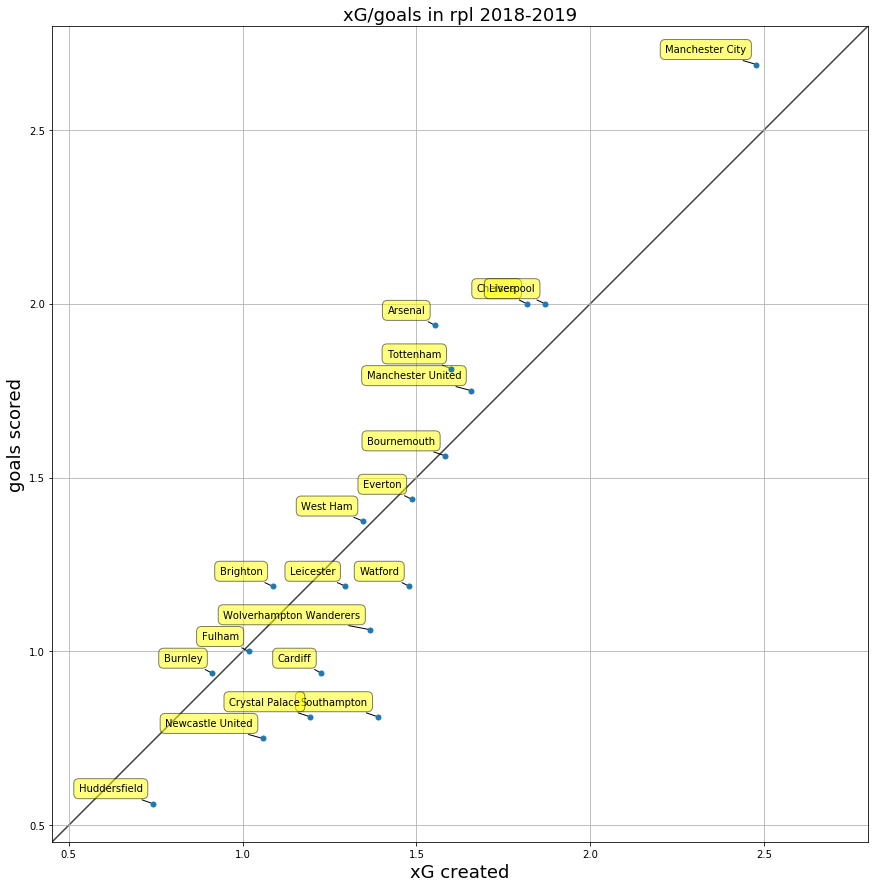

In [325]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(xG_goals['xG_per_match'], xG_goals['goal_per_match'],s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()]),]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

for label, x, y in zip(xG_goals.index, xG_goals['xG_per_match'].values, xG_goals['goal_per_match'].values):
    plt.annotate(label, xy=(x, y), xytext=(-10, 10), textcoords='offset points', ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))


plt.title('xG/goals in rpl 2018-2019', fontsize=18)
plt.xlabel('xG created', fontsize=18)
plt.ylabel('goals scored', fontsize=18)
plt.grid()

Получим данные по игрокам.

In [326]:
player_ids = set(data_test['player_name'].values)
goal_players = dict()
xG_players = dict()
for i in player_ids:
    goal_players[i] = goal_players.get(i, 0) + data_test[(data_test['player_name'] == i)  & (data_test['is_penalty'] == 0)]['is_goal'].sum()
    xG_players[i] = xG_players.get(i, 0) + data_test[(data_test['player_name'] == i) & (data_test['is_penalty'] == 0)]['XG'].sum()

In [327]:
goal_players = pd.DataFrame(list(goal_players.items()), columns=['Name', 'G']).sort_values('G', ascending=False)

In [328]:
xG_players = pd.DataFrame(list(xG_players.items()), columns=['Name', 'xG']).sort_values('xG', ascending=False)

In [329]:
table_players = xG_players.set_index('Name').join(goal_players.set_index('Name'))

In [330]:
table_players.head(30)

,xG,G
Name,,
Mohamed Salah,8.352996,10
Sergio Agüero,7.611987,8
Pierre-Emerick Aubameyang,7.298605,9
Callum Wilson,6.847561,7
Harry Kane,6.586223,6
Álvaro Morata,6.048216,5
Aleksandar Mitrovic,5.793340,7
Raheem Sterling,5.516272,8
Romelu Lukaku,5.438462,6


In [265]:
table_players.to_csv('players_rpl_18-19.csv', index=None)

In [331]:
mean_distance = dict()
xG_shot = dict()
goal_shot = dict()
for i in table_players[:30].index:
    mean_distance[i] = data_test[(data_test['player_name'] == i) & (data_test['is_penalty'] == 0)]['distance'].mean()
    xG_shot[i] = data_test[(data_test['player_name'] == i)  & (data_test['is_penalty'] == 0)]['XG'].sum() / data_test[data_test['player_name'] == i].shape[0]
    goal_shot[i] = data_test[(data_test['player_name'] == i)  & (data_test['is_penalty'] == 0)]['is_goal'].sum() / data_test[data_test['player_name'] == i].shape[0]

In [332]:
mean_distance = pd.DataFrame(list(mean_distance.items()), columns=['Name', 'distance']).sort_values('distance', ascending=False)

In [333]:
xG_shot = pd.DataFrame(list(xG_shot.items()), columns=['Name', 'xG_shot']).sort_values('xG_shot', ascending=False)

In [334]:
goal_shot = pd.DataFrame(list(goal_shot.items()), columns=['Name', 'goal_shot']).sort_values('goal_shot', ascending=False)

In [335]:
table_shots = xG_shot.set_index('Name').join(goal_shot.set_index('Name'))

In [336]:
table_shots = table_shots.join(mean_distance.set_index('Name'))

In [337]:
table_shots.sort_values('xG_shot', ascending=False)

,xG_shot,goal_shot,distance
Name,,,
Chicharito,0.256882,0.235294,12.298273
Gabriel Jesus,0.202932,0.043478,11.561370
Pierre-Emerick Aubameyang,0.197260,0.243243,13.989343
Romelu Lukaku,0.194231,0.214286,11.344322
Callum Wilson,0.190210,0.194444,11.265371
Álvaro Morata,0.189007,0.156250,13.481795
Jamie Vardy,0.175490,0.076923,11.344321
Raheem Sterling,0.172384,0.250000,13.757441
Leroy Sané,0.171146,0.230769,14.011843


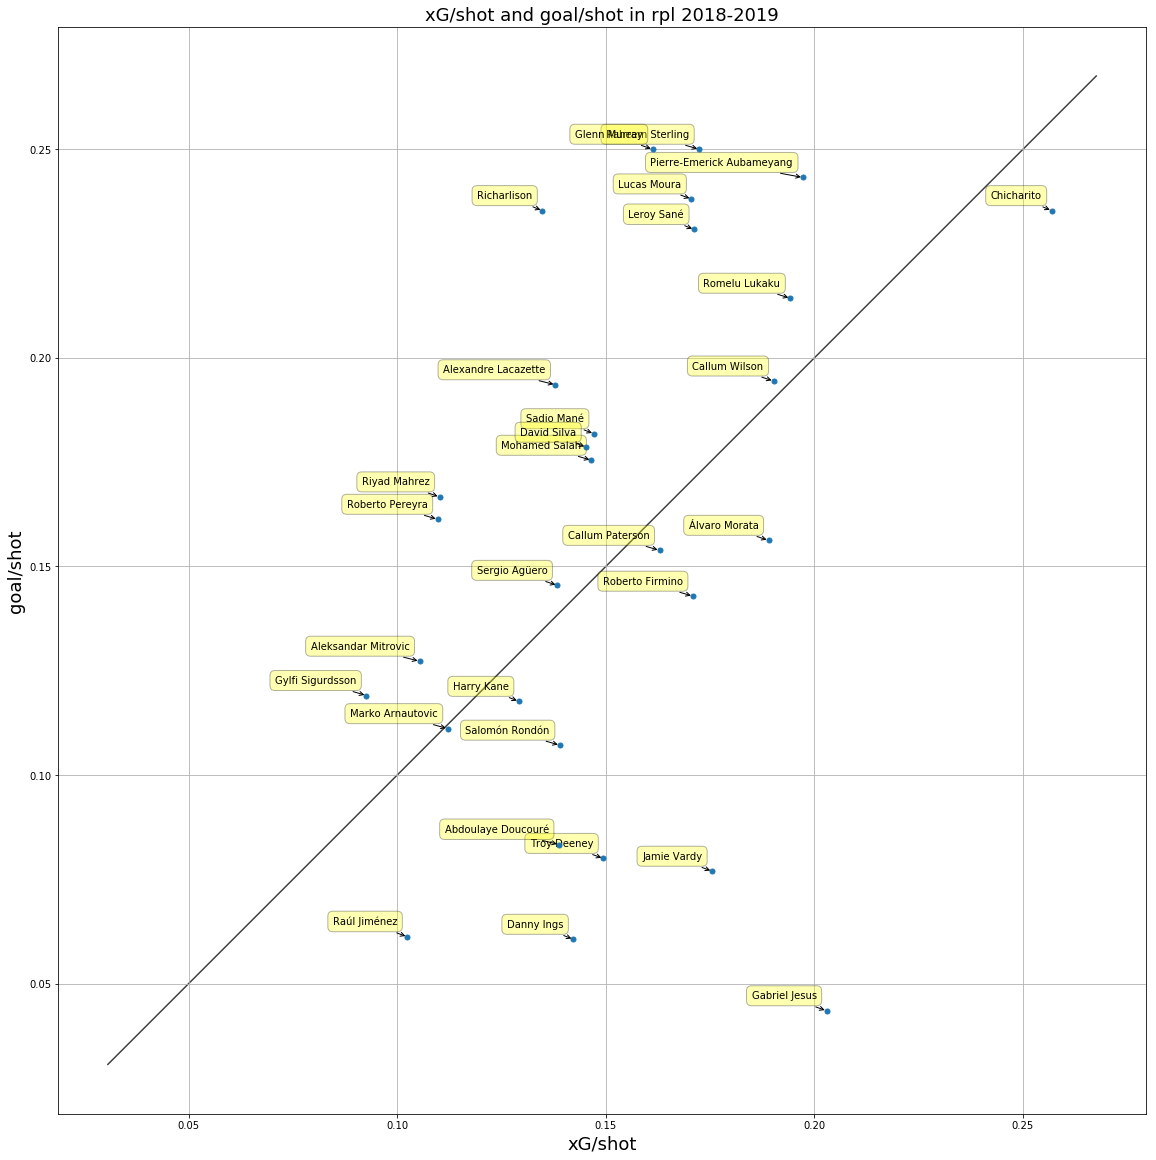

In [338]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.scatter(table_shots[:30]['xG_shot'].values, table_shots[:30]['goal_shot'],s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),np.max([ax.get_xlim(), ax.get_ylim()]),]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
for label, x, y in zip(table_shots[:30].index, table_shots[:30]['xG_shot'].values, table_shots[:30]['goal_shot']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.title('xG/shot and goal/shot in rpl 2018-2019', fontsize=18)
plt.xlabel('xG/shot', fontsize=18)
plt.ylabel('goal/shot', fontsize=18)
plt.grid()

In [283]:
table_shots.to_csv('table_shots_rpl_18-19.csv', index=None)

In [339]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(data_test['is_goal'].values, data_test['XG'].values))

0.2745622301559199

In [340]:
from sklearn.metrics import roc_auc_score
roc_auc_score(data_test['is_goal'].values, data_test['XG'].values)

0.796869603421304